In [1]:
import numpy as np
import pandas as pd
import numba

from glob import glob
import os
import subprocess
from tqdm import tqdm 

import skimage
import skimage.io as io
import imageio
from openpiv import tools, preprocess, pyprocess, validation, filters, scaling

import bokeh.io
import colorcet as cc
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline
%load_ext blackcellmagic

In [2]:
# def get_velocity_field(
#     frame_a,
#     frame_b,
#     window_size=64,
#     search_area_size=64,
#     overlap=16,
#     frame_rate=None,
#     time_interval=None,
#     scaling_factor=96.52,
#     *args,
#     **kwargs
# ):
#     masked_a = preprocess.dynamic_masking(
#         frame_a, method="edges", filter_size=50, threshold=1e-2
#     )
#     masked_b = preprocess.dynamic_masking(
#         frame_b, method="edges", filter_size=50, threshold=1e-2
#     )

#     if time_interval is None:
#         assert frame_rate is not None, "Must specify `frame_rate` or `time_interval`."
#         time_interval = 1 / frame_rate

#     u, v, sig2noise = pyprocess.extended_search_area_piv(
#         masked_a.astype(np.int32),
#         masked_b.astype(np.int32),
#         window_size=window_size,
#         overlap=overlap,
#         dt=time_interval,
#         search_area_size=search_area_size,
#         sig2noise_method="peak2peak",
#     )

#     x, y = pyprocess.get_coordinates(
#         image_size=masked_a.shape, window_size=window_size, overlap=overlap
#     )
#     u, v, mask = validation.global_std(u, v)
#     u, v = filters.replace_outliers(u, v, method="localmean", max_iter=3, kernel_size=3)
#     x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor=scaling_factor)

#     return np.array((x, y, u, v, mask), dtype=np.float32)


# def clean_image(path, print_updates=False):
    
#     if print_updates:
#         print(f"Cleaning {path}")
    
#     # Read blue channel of RBG images
#     im = io.imread(path)[:, :, 2]
    
#     # Cover timestamp with median mask
#     mask = np.s_[1300:1380, 1400:1600]
#     im = skimage.img_as_float(im)
#     im[mask] = np.median(im)
    
#     # Normalize luminance
#     im = (im - im.min()) / (im.max() - im.min())
    
#     # Filter the image with a strong Gaussian blur
#     im_bg = skimage.filters.gaussian(im, 50.0)
    
#     # Subtract background
#     im = im - im_bg
    
#     return im


# @numba.njit
# def get_speeds(u, v):
#     return np.sqrt(u.ravel()**2 + v.ravel()**2)

In [ ]:
# speed_dfs = []
# avis = glob("C:/Users/Pranav/Documents/transceiver-density-overlay/*.avi")
# avis = [os.path.abspath(i) for i in avis]

In [3]:
from pathlib import Path


data_dir = Path("../data")
timelapse_dir = data_dir.joinpath("time_lapse")

In [16]:
im_files = list(timelapse_dir.glob("*.tiff"))

ims_f = str(im_files[0])
# ims_collection = io.imread_collection([str(f) for f in im_files])

ims = io.imread(ims_f)

In [17]:
ims.shape

(163, 1440, 1920)

In [23]:
def get_velocity_field(
    image_a,
    image_b,
    window_size=64,
    search_area_size=64,
    overlap=16,
    frame_rate=None,
    time_interval=None,
    scaling_factor=96.52,
    *args,
    **kwargs
):
    if time_interval is None:
        assert frame_rate is not None, "Must specify `frame_rate` or `time_interval`."
        time_interval = 1 / frame_rate

    u, v, sig2noise = pyprocess.extended_search_area_piv(
        image_a.astype(np.int32),
        image_b.astype(np.int32),
        window_size=window_size,
        overlap=overlap,
        dt=time_interval,
        search_area_size=search_area_size,
        sig2noise_method="peak2peak",
    )

    x, y = pyprocess.get_coordinates(
        image_size=image_a.shape, window_size=window_size, overlap=overlap
    )
    
    return x, y, u, v
    
    # u, v, mask = validation.global_std(u, v)
    # u, v = filters.replace_outliers(u, v, method="localmean", max_iter=3, kernel_size=3)
    # x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor=scaling_factor)

    # return np.array((x, y, u, v, mask), dtype=np.float32)


In [65]:
filter_sizes = 5, 10, 25, 50, 100, 200


masked = [
    preprocess.dynamic_masking(a, method="edges", filter_size=f)[0]
    for f in filter_sizes
]

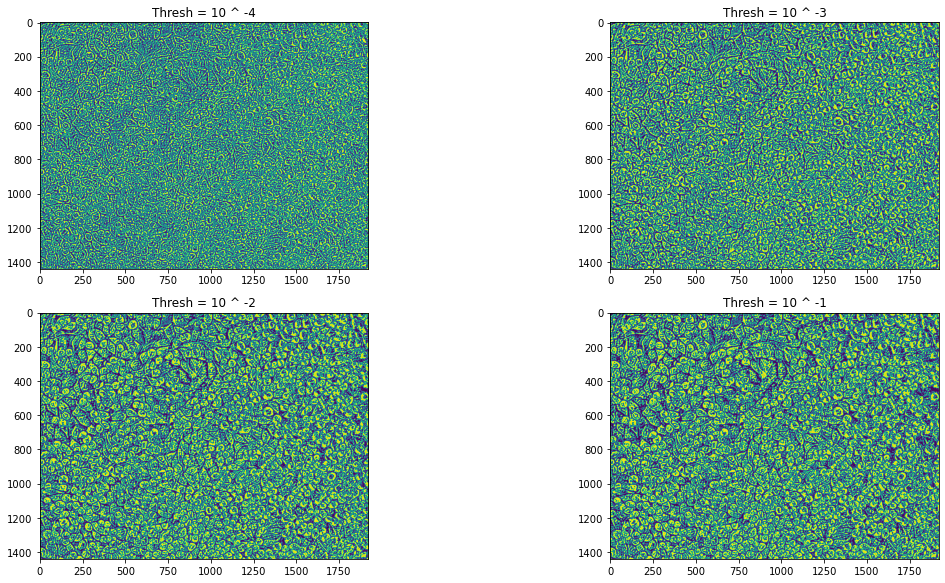

In [64]:
fig = plt.figure(figsize=(16, 12))

for i in range(4):
    
    fig.add_subplot(3, 2, i + 1)
    plt.title(f"Thresh = 10 ^ {i - 4}")
    
    plt.imshow(masked[i])

plt.tight_layout()

In [36]:
mb[0].max()

255

In [22]:
vel_data = []

frame_skip = 50

n_frames, *imshape = ims.shape
for i in range(0, n_frames, frame_skip):
    x, y, u, v = get_velocity_field(ims[i], ims[i + 1], time_interval = 1)
    
    vel_data.append(tuple(x, y, u, v))

AttributeError: 'tuple' object has no attribute 'astype'